In [4]:
# load and plot dataset
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
%matplotlib inline

In [5]:
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('data/shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# summarize first few rows
print(series.head())

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64


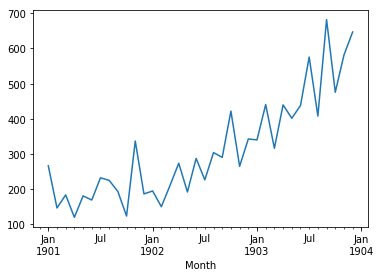

In [6]:
# line plot
series.plot()
pyplot.show()

### Baseline Model

In [11]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from math import sqrt
import matplotlib
# be able to save images on server
matplotlib.use('Agg')
from matplotlib import pyplot
import numpy

In [11]:
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

In [11]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	return df

In [11]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

In [11]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [11]:
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

In [11]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
	new_row = [x for x in X] + [yhat]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

In [11]:
# fit an LSTM network to training data
def fit_lstm(train, n_batch, nb_epoch, n_neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
		model.reset_states()
	return model

In [11]:
# run a repeated experiment
def experiment(series, n_lag, n_repeats, n_epochs, n_batch, n_neurons):
	# transform data to be stationary
	raw_values = series.values
	diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, n_lag)
	supervised_values = supervised.values[n_lag:,:]
	# split data into train and test-sets
	train, test = supervised_values[0:-12], supervised_values[-12:]
	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)
	# run experiment
	error_scores = list()
	for r in range(n_repeats):
		# fit the model
		train_trimmed = train_scaled[2:, :]
		lstm_model = fit_lstm(train_trimmed, n_batch, n_epochs, n_neurons)
		# forecast test dataset
		test_reshaped = test_scaled[:,0:-1]
		test_reshaped = test_reshaped.reshape(len(test_reshaped), 1, 1)
		output = lstm_model.predict(test_reshaped, batch_size=n_batch)
		predictions = list()
		for i in range(len(output)):
			yhat = output[i,0]
			X = test_scaled[i, 0:-1]
			# invert scaling
			yhat = invert_scale(scaler, X, yhat)
			# invert differencing
			yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
			# store forecast
			predictions.append(yhat)
		# report performance
		rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
		print('%d) Test RMSE: %.3f' % (r+1, rmse))
		error_scores.append(rmse)
	return error_scores

In [11]:
# configure the experiment
def run():
	# load dataset
	series = read_csv('data/shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
	# configure the experiment
	n_lag = 1
	n_repeats = 5
	n_epochs = 5
	n_batch = 4
	n_neurons = 3
	# run the experiment
	results = DataFrame()
	results['results'] = experiment(series, n_lag, n_repeats, n_epochs, n_batch, n_neurons)
	# summarize results
	print(results.describe())
	# save boxplot
	results.boxplot()
	pyplot.savefig('experiment_baseline.png')

1) Test RMSE: 137.222
2) Test RMSE: 128.747
3) Test RMSE: 135.567
4) Test RMSE: 137.910
5) Test RMSE: 125.726
6) Test RMSE: 131.636
7) Test RMSE: 135.244
8) Test RMSE: 140.844
9) Test RMSE: 130.388
10) Test RMSE: 159.611
11) Test RMSE: 128.385
12) Test RMSE: 144.837
13) Test RMSE: 140.577
14) Test RMSE: 142.959
15) Test RMSE: 135.150
16) Test RMSE: 134.668
17) Test RMSE: 137.115
18) Test RMSE: 128.800
19) Test RMSE: 149.800
20) Test RMSE: 127.157
21) Test RMSE: 126.604
22) Test RMSE: 122.036
23) Test RMSE: 126.257
24) Test RMSE: 134.184
25) Test RMSE: 124.945
26) Test RMSE: 118.329
27) Test RMSE: 132.536
28) Test RMSE: 131.579
29) Test RMSE: 138.643
30) Test RMSE: 132.201
          results
count   30.000000
mean   133.988548
std      8.454420
min    118.328819
25%    128.475013
50%    133.359649
75%    137.738357
max    159.611285


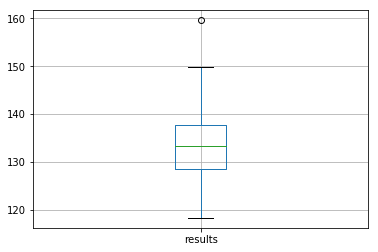

In [11]:
# entry point
run()

### Evaluation 

In [12]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from math import sqrt
import matplotlib
# be able to save images on server
matplotlib.use('Agg')
from matplotlib import pyplot
import numpy

In [12]:
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

In [12]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	return df

In [12]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

In [12]:
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

In [12]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
	new_row = [x for x in X] + [yhat]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

In [12]:
# evaluate the model on a dataset, returns RMSE in transformed units
def evaluate(model, raw_data, scaled_dataset, scaler, offset, batch_size):
	# separate
	X, y = scaled_dataset[:,0:-1], scaled_dataset[:,-1]
	# reshape
	reshaped = X.reshape(len(X), 1, 1)
	# forecast dataset
	output = model.predict(reshaped, batch_size=batch_size)
	# invert data transforms on forecast
	predictions = list()
	for i in range(len(output)):
		yhat = output[i,0]
		# invert scaling
		yhat = invert_scale(scaler, X[i], yhat)
		# invert differencing
		yhat = yhat + raw_data[i]
		# store forecast
		predictions.append(yhat)
	# report performance
	rmse = sqrt(mean_squared_error(raw_data[1:], predictions))
	# reset model state
	model.reset_states()
	return rmse

In [12]:
# fit an LSTM network to training data
def fit_lstm(train, test, raw, scaler, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	# prepare model
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	# fit model
	train_rmse, test_rmse = list(), list()
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
		# evaluate model on train data
		raw_train = raw[-(len(train)+len(test)+1):-len(test)]
		train_rmse.append(evaluate(model, raw_train, train, scaler, 0, batch_size))
		# evaluate model on test data
		raw_test = raw[-(len(test)+1):]
		test_rmse.append(evaluate(model, raw_test, test, scaler, 0, batch_size))
	history = DataFrame()
	history['train'], history['test'] = train_rmse, test_rmse
	return history

In [12]:
# run diagnostic experiments
def run():
	# config
	n_lag = 1
	n_repeats = 5
	n_epochs = 5
	n_batch = 4
	n_neurons = 3
	# load dataset
	series = read_csv('data/shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
	# transform data to be stationary
	raw_values = series.values
	diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, n_lag)
	supervised_values = supervised.values[n_lag:,:]
	# split data into train and test-sets
	train, test = supervised_values[0:-12], supervised_values[-12:]
	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)
	# fit and evaluate model
	train_trimmed = train_scaled[2:, :]
	# run diagnostic tests
	for i in range(n_repeats):
		history = fit_lstm(train_trimmed, test_scaled, raw_values, scaler, n_batch, n_epochs, n_neurons)
		pyplot.plot(history['train'], color='blue')
		pyplot.plot(history['test'], color='orange')
		print('%d) TrainRMSE=%f, TestRMSE=%f' % (i+1, history['train'].iloc[-1], history['test'].iloc[-1]))
	pyplot.savefig('diagnostic_baseline.png')

1) TrainRMSE=89.013722, TestRMSE=131.576194
2) TrainRMSE=88.695386, TestRMSE=130.146087
3) TrainRMSE=88.931687, TestRMSE=131.294474
4) TrainRMSE=101.506521, TestRMSE=148.219614
5) TrainRMSE=91.151394, TestRMSE=133.666481


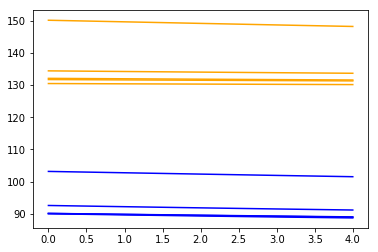

In [12]:
# entry point
run()

### Input Dropout

In [13]:
# fit an LSTM network to training data
def fit_lstm(train, n_batch, nb_epoch, n_neurons, dropout):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True, dropout=dropout))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
		model.reset_states()
	return model

In [13]:
# run a repeated experiment
def experiment(series, n_lag, n_repeats, n_epochs, n_batch, n_neurons, dropout):
	# transform data to be stationary
	raw_values = series.values
	diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, n_lag)
	supervised_values = supervised.values[n_lag:,:]
	# split data into train and test-sets
	train, test = supervised_values[0:-12], supervised_values[-12:]
	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)
	# run experiment
	error_scores = list()
	for r in range(n_repeats):
		# fit the model
		train_trimmed = train_scaled[2:, :]
		lstm_model = fit_lstm(train_trimmed, n_batch, n_epochs, n_neurons, dropout)
		# forecast test dataset
		test_reshaped = test_scaled[:,0:-1]
		test_reshaped = test_reshaped.reshape(len(test_reshaped), 1, 1)
		output = lstm_model.predict(test_reshaped, batch_size=n_batch)
		predictions = list()
		for i in range(len(output)):
			yhat = output[i,0]
			X = test_scaled[i, 0:-1]
			# invert scaling
			yhat = invert_scale(scaler, X, yhat)
			# invert differencing
			yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
			# store forecast
			predictions.append(yhat)
		# report performance
		rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
		print('%d) Test RMSE: %.3f' % (r+1, rmse))
		error_scores.append(rmse)
	return error_scores

In [13]:
# configure the experiment
def run():
	# load dataset
	series = read_csv('data/shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
	# configure the experiment
	n_lag = 1
	n_repeats = 5
	n_epochs = 5
	n_batch = 4
	n_neurons = 3
	n_dropout = [0.0, 0.2, 0.4, 0.6]
	# run the experiment
	results = DataFrame()
	for dropout in n_dropout:
		results[str(dropout)] = experiment(series, n_lag, n_repeats, n_epochs, n_batch, n_neurons, dropout)
	# summarize results
	print(results.describe())
	# save boxplot
	results.boxplot()
	pyplot.savefig('experiment_dropout_input.png')
    

1) Test RMSE: 129.450
2) Test RMSE: 136.616
3) Test RMSE: 122.478
4) Test RMSE: 133.163


W0601 11:15:15.993562 4599838144 deprecation.py:506] From /Users/bargava/anaconda3/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:4081: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


5) Test RMSE: 140.781
1) Test RMSE: 146.758
2) Test RMSE: 123.982
3) Test RMSE: 135.483
4) Test RMSE: 148.908
5) Test RMSE: 131.522
1) Test RMSE: 131.415
2) Test RMSE: 135.921
3) Test RMSE: 152.006
4) Test RMSE: 127.188
5) Test RMSE: 123.428
1) Test RMSE: 128.192
2) Test RMSE: 132.113
3) Test RMSE: 127.939
4) Test RMSE: 137.450
5) Test RMSE: 129.436
              0.0         0.2         0.4         0.6
count    5.000000    5.000000    5.000000    5.000000
mean   132.497777  137.330533  133.991520  131.026009
std      6.994764   10.467070   11.099206    3.954269
min    122.477801  123.982147  123.428165  127.938783
25%    129.450371  131.521715  127.187508  128.191515
50%    133.163380  135.483334  131.415082  129.436190
75%    136.615978  146.757593  135.920576  132.113399
max    140.781356  148.907876  152.006269  137.450161


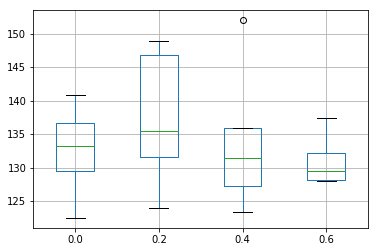

In [13]:
run()

### Recurrent dropout

In [15]:
# fit an LSTM network to training data
def fit_lstm(train, n_batch, nb_epoch, n_neurons, dropout):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True, recurrent_dropout=dropout))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
		model.reset_states()
	return model

In [15]:
# run a repeated experiment
def experiment(series, n_lag, n_repeats, n_epochs, n_batch, n_neurons, dropout):
	# transform data to be stationary
	raw_values = series.values
	diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, n_lag)
	supervised_values = supervised.values[n_lag:,:]
	# split data into train and test-sets
	train, test = supervised_values[0:-12], supervised_values[-12:]
	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)
	# run experiment
	error_scores = list()
	for r in range(n_repeats):
		# fit the model
		train_trimmed = train_scaled[2:, :]
		lstm_model = fit_lstm(train_trimmed, n_batch, n_epochs, n_neurons, dropout)
		# forecast test dataset
		test_reshaped = test_scaled[:,0:-1]
		test_reshaped = test_reshaped.reshape(len(test_reshaped), 1, 1)
		output = lstm_model.predict(test_reshaped, batch_size=n_batch)
		predictions = list()
		for i in range(len(output)):
			yhat = output[i,0]
			X = test_scaled[i, 0:-1]
			# invert scaling
			yhat = invert_scale(scaler, X, yhat)
			# invert differencing
			yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
			# store forecast
			predictions.append(yhat)
		# report performance
		rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
		print('%d) Test RMSE: %.3f' % (r+1, rmse))
		error_scores.append(rmse)
	return error_scores

1) Test RMSE: 138.266
2) Test RMSE: 129.756
3) Test RMSE: 124.681
4) Test RMSE: 132.928
5) Test RMSE: 130.314
1) Test RMSE: 122.707
2) Test RMSE: 130.469
3) Test RMSE: 129.674
4) Test RMSE: 130.402
5) Test RMSE: 147.296
1) Test RMSE: 126.400
2) Test RMSE: 121.290
3) Test RMSE: 131.477
4) Test RMSE: 134.630
5) Test RMSE: 131.718
1) Test RMSE: 136.480
2) Test RMSE: 124.821
3) Test RMSE: 135.525
4) Test RMSE: 134.020
5) Test RMSE: 128.994
              0.0         0.2         0.4         0.6
count    5.000000    5.000000    5.000000    5.000000
mean   131.189061  132.109697  129.103009  131.968030
std      4.956789    9.090807    5.276471    4.928182
min    124.681229  122.707301  121.290156  124.820949
25%    129.755873  129.674184  126.400421  128.993881
50%    130.313861  130.402008  131.476647  134.020216
75%    132.928434  130.468921  131.717666  135.525381
max    138.265907  147.296072  134.630153  136.479724


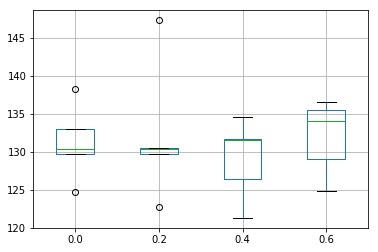

In [15]:
# configure the experiment
def run():
	# load dataset
	series = read_csv('data/shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
	# configure the experiment
	n_lag = 1
	n_repeats = 5
	n_epochs = 5
	n_batch = 4
	n_neurons = 3
	n_dropout = [0.0, 0.2, 0.4, 0.6]
	# run the experiment
	results = DataFrame()
	for dropout in n_dropout:
		results[str(dropout)] = experiment(series, n_lag, n_repeats, n_epochs, n_batch, n_neurons, dropout)
	# summarize results
	print(results.describe())
	# save boxplot
	results.boxplot()
	pyplot.savefig('experiment_dropout_recurrent.png')
    
run()

### Comparison to baseline

In [17]:
# fit an LSTM network to training data
def fit_lstm(train, test, raw, scaler, batch_size, nb_epoch, neurons, dropout):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	# prepare model
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True, recurrent_dropout=dropout))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	# fit model
	train_rmse, test_rmse = list(), list()
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
		# evaluate model on train data
		raw_train = raw[-(len(train)+len(test)+1):-len(test)]
		train_rmse.append(evaluate(model, raw_train, train, scaler, 0, batch_size))
		# evaluate model on test data
		raw_test = raw[-(len(test)+1):]
		test_rmse.append(evaluate(model, raw_test, test, scaler, 0, batch_size))
	history = DataFrame()
	history['train'], history['test'] = train_rmse, test_rmse
	return history

In [18]:
# run diagnostic experiments
def run():
	# config
	n_lag = 1
	n_repeats = 10
	n_epochs = 1000
	n_batch = 4
	n_neurons = 3
	dropout = 0.4
	# load dataset
	series = read_csv('data/shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
	# transform data to be stationary
	raw_values = series.values
	diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, n_lag)
	supervised_values = supervised.values[n_lag:,:]
	# split data into train and test-sets
	train, test = supervised_values[0:-12], supervised_values[-12:]
	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)
	# fit and evaluate model
	train_trimmed = train_scaled[2:, :]
	# run diagnostic tests
	for i in range(n_repeats):
		history = fit_lstm(train_trimmed, test_scaled, raw_values, scaler, n_batch, n_epochs, n_neurons, dropout)
		pyplot.plot(history['train'], color='blue')
		pyplot.plot(history['test'], color='orange')
		print('%d) TrainRMSE=%f, TestRMSE=%f' % (i+1, history['train'].iloc[-1], history['test'].iloc[-1]))
	pyplot.savefig('diagnostic_dropout_recurrent.png')
 

1) TrainRMSE=57.061417, TestRMSE=96.351091
2) TrainRMSE=58.533706, TestRMSE=93.088980
3) TrainRMSE=59.225100, TestRMSE=94.538009
4) TrainRMSE=58.896696, TestRMSE=95.216141
5) TrainRMSE=59.082575, TestRMSE=97.284028
6) TrainRMSE=58.237347, TestRMSE=101.244749
7) TrainRMSE=58.603615, TestRMSE=89.756791
8) TrainRMSE=59.781443, TestRMSE=86.135846
9) TrainRMSE=59.343616, TestRMSE=87.829998
10) TrainRMSE=58.473215, TestRMSE=98.068618


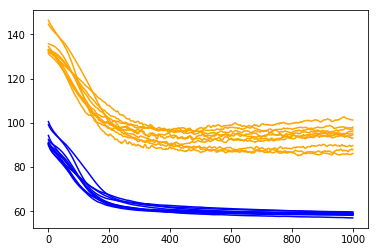

In [19]:
run()